In [1]:
# Check GPU type
!nvidia-smi

Mon Oct  7 18:33:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install ultralytics
!pip -q install  ultralytics

In [3]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Path to where your data is stored
DATA_DIR = Path('/kaggle/input/csv-malariya')

# Preview data files available
os.listdir(DATA_DIR)

['SampleSubmission.csv', 'Train.csv', 'Test.csv']

In [5]:
# Set up directoris for training a yolo model

# Images directories
DATASET_DIR = Path('datasets/dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

In [6]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

# Add an image_path column
train['image_path'] = [Path('/kaggle/input/malariya/' + x) for x in train.Image_ID]
test['image_path'] = [Path('/kaggle/input/malariya/' + x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
train['class_id'] = train['class'].map({'Trophozoite': 0, 'WBC': 1, 'NEG': 2})

# Preview the head of the train set
train.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,image_path,class_id
0,id_u3q6jdck4j.jpg,Trophozoite,1.0,712,1241,737,1270,/kaggle/input/malariya/id_u3q6jdck4j.jpg,0
1,id_a6cl90trri.jpg,Trophozoite,1.0,558,1566,600,1604,/kaggle/input/malariya/id_a6cl90trri.jpg,0
2,id_qvc2le9sm8.jpg,Trophozoite,1.0,1317,2788,1448,2914,/kaggle/input/malariya/id_qvc2le9sm8.jpg,0
3,id_w8xnbd5rvm.jpg,Trophozoite,1.0,925,1744,1041,1823,/kaggle/input/malariya/id_w8xnbd5rvm.jpg,0
4,id_6dop09rk02.jpg,NEG,1.0,0,0,0,0,/kaggle/input/malariya/id_6dop09rk02.jpg,2


In [7]:
# Filter out NEG class (Negative images - this images have no Trophozoite nor WBC in them)
# Yolo reccomends that when creating labels for negative images, you leave them empty
# https://github.com/ultralytics/yolov5/issues/3218
# As this is a starter nb, we will ignore the negative images
train = train[~(train['class'] == 'NEG')].reset_index(drop = True)

In [8]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.20, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((18542, 9), (4300, 9))

In [9]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Trophozoite    0.690217
 WBC            0.309783
 Name: proportion, dtype: float64,
 class
 Trophozoite    0.706977
 WBC            0.293023
 Name: proportion, dtype: float64)

In [10]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
  if DIR.exists():
    shutil.rmtree(DIR)
  DIR.mkdir(parents=True, exist_ok = True)

In [11]:
# Copy train, val and test images to their respective dirs
for img in tqdm(X_train.image_path.unique()):
  shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

for img in tqdm(X_val.image_path.unique()):
  shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

for img in tqdm(test.image_path.unique()):
  shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1])

  0%|          | 0/1647 [00:00<?, ?it/s]

  0%|          | 0/412 [00:00<?, ?it/s]

  0%|          | 0/1178 [00:00<?, ?it/s]

In [12]:
# import os
# from PIL import Image

# # Define the folder containing images
# folder_path = "/kaggle/working/datasets/dataset/images/train"

# # Store the dimensions of the first image
# first_image_shape = None
# all_same_shape = True

# # Iterate over all files in the folder
# for filename in os.listdir(folder_path):
#     if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Add more extensions if needed
#         image_path = os.path.join(folder_path, filename)
#         with Image.open(image_path) as img:
#             current_image_shape = img.size  # (width, height)

#             # Set the first image shape if not set
#             if first_image_shape is None:
#                 first_image_shape = current_image_shape
#             else:
#                 # Compare current image shape with the first image shape
#                 if current_image_shape != first_image_shape:
#                     all_same_shape = False
#                     print(f"Image '{filename}' has a different shape: {current_image_shape}")
#                     break

# # Final result
# if all_same_shape:
#     print("All images have the same shape:", first_image_shape)
# else:
#     print("Not all images have the same shape.")


In [13]:
# from PIL import Image
# import os

# # Set the directory containing your images
# image_folder = "/kaggle/input/malariya"

# # Dictionary to store unique shapes
# unique_shapes = {}

# # Iterate through all files in the directory
# for filename in os.listdir(image_folder):
#     if filename.endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):  # Add image formats as needed
#         # Open the image file
#         with Image.open(os.path.join(image_folder, filename)) as img:
#             # Get the image shape (width, height)
#             shape = img.size  # img.size returns (width, height)

#             # Store the filename under the corresponding shape in the dictionary
#             if shape not in unique_shapes:
#                 unique_shapes[shape] = []
#             unique_shapes[shape].append(filename)

# # Check if all images have the same shape
# if len(unique_shapes) == 1:
#     print("All images have the same shape:", list(unique_shapes.keys())[0])
# else:
#     print("Images have different shapes. Here are the unique shapes and the corresponding files:")
#     for shape, files in unique_shapes.items():
#         print(f"Shape: {shape}, Number of images: {len(files)}")
# #         print("Files:", files)


## Train

Images have different shapes. Here are the unique shapes and the corresponding files:

- **Shape**: (1920, 1080), **Number of images**: 770
- **Shape**: (4160, 3120), **Number of images**: 270
- **Shape**: (4032, 3016), **Number of images**: 607


In [14]:
# Function to convert the bboxes to yolo format and save them
def save_yolo_annotation(row):
    image_path, class_id, output_dir = row['image_path'], row['class_id'], row['output_dir']

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from path: {image_path}")

    height, width, _ = img.shape

    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"

    ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']

    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    with open(label_file, 'a') as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

# Parallelize the annotation saving process
def process_dataset(dataframe, output_dir):
    dataframe['output_dir'] = output_dir
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap(save_yolo_annotation, dataframe.to_dict('records')), total=len(dataframe)))

# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)
process_dataset(X_val, VAL_LABELS_DIR)

/tmp/ipykernel_23/3126062312.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir


  0%|          | 0/18542 [00:00<?, ?it/s]

/tmp/ipykernel_23/3126062312.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir


  0%|          | 0/4300 [00:00<?, ?it/s]

In [15]:
# Train images dir
TRAIN_IMAGES_DIR

PosixPath('datasets/dataset/images/train')

In [16]:
# Create a data.yaml file required by yolo
class_names = train['class'].unique().tolist()
num_classes = len(class_names)

data_yaml = {
    'train': '/kaggle/working/' + str(TRAIN_IMAGES_DIR),
    'val': '/kaggle/working/' + str(VAL_IMAGES_DIR),
    'test': '/kaggle/working/' + str(TEST_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'train': '/kaggle/working/datasets/dataset/images/train',
 'val': '/kaggle/working/datasets/dataset/images/val',
 'test': '/kaggle/working/datasets/dataset/images/test',
 'nc': 2,
 'names': ['Trophozoite', 'WBC']}

Plotting id_adv10hddfp.jpg with 7 bounding boxes.


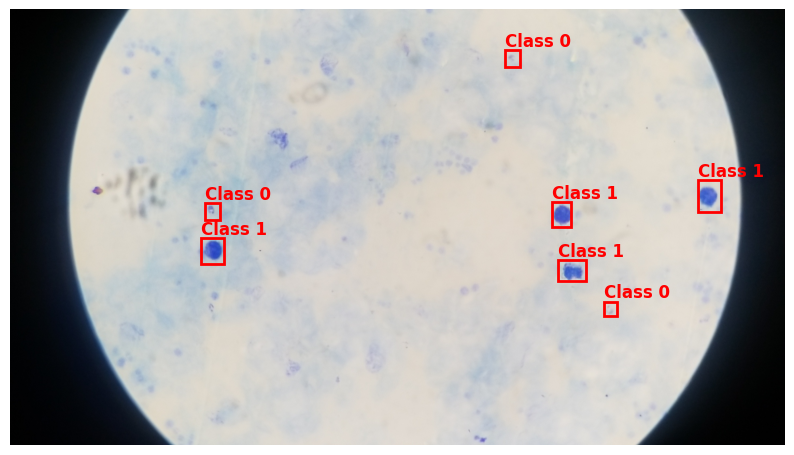

Plotting id_gwr0e1k48a.jpg with 2 bounding boxes.


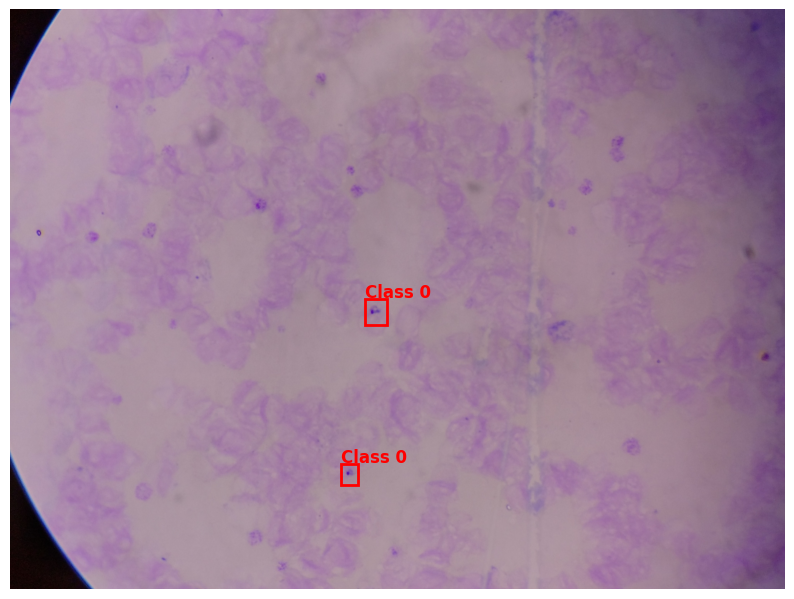

Plotting id_7wk6y42ce8.jpg with 23 bounding boxes.


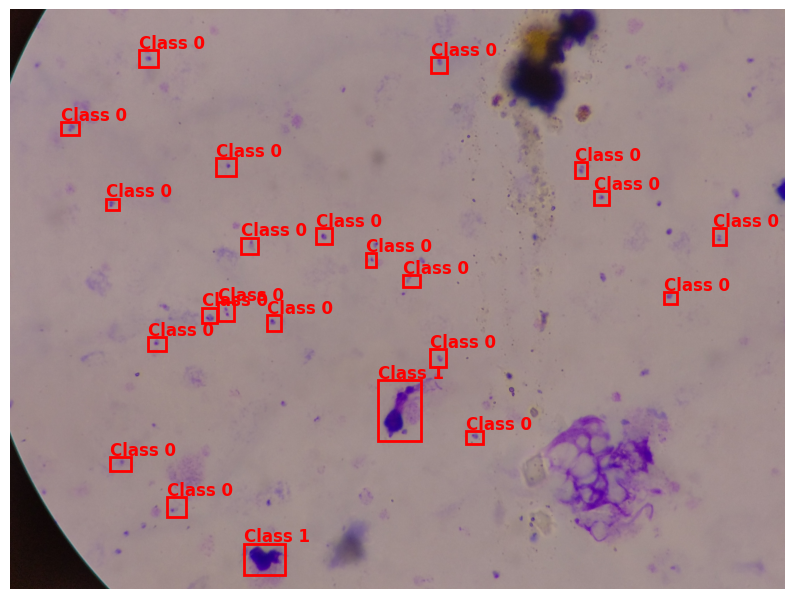

In [17]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:3]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [18]:
# import gc
# import torch
# # del model
# gc.collect()
# torch.cuda.empty_cache()


In [19]:
!nvidia-smi

Mon Oct  7 18:41:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
import wandb
wandb.login(key="3b300f8458c36ed9b9080e91bf7fe5f3dab62a68")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [21]:
# Load a yolo pretrained model
model = YOLO("yolov8m.pt")

# Fine tune model to our data
model.train(
    data='data.yaml',          # Path to the dataset configuration
    epochs=150,                 # Number of epochs
    imgsz=1024,                # Image size (height, width)
    batch=8,                   # Batch size
    device=0,                  # Device to use (0 for the first GPU)
    patience=15,
    save= True,
    save_period = 10,
    cache = True,
    seed = 999,
#     rect = True,
#     cos_lr =  True,
    amp = False,
    freeze = False,
    plots = True
#     degrees = 90,
#     shear = 90,
#     perspective =  0.0001,
#     flipud = 0.5,
#     fliplr = 0.5,
#     mixup = 0.3,
#     copy_paste = 0.5
    
    
    



)

100%|██████████| 49.7M/49.7M [00:00<00:00, 307MB/s]


Ultralytics 8.3.7 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=150, time=None, patience=15, batch=8, imgsz=1024, save=True, save_period=10, cache=True, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=999, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=False, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_

100%|██████████| 755k/755k [00:00<00:00, 20.0MB/s]
2024-10-07 18:41:21,867	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-07 18:41:22,391	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

wandb: Currently logged in as: manik-tensor (manik-tensor-bangladesh-university-of-engineering-and-te). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241007_184135-yau1pjak
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train
wandb: ⭐️ View project at https://wandb.ai/manik-tensor-bangladesh-university-of-engineering-and-te/YOLOv8
wandb: 🚀 View run at https://wandb.ai/manik-tensor-bangladesh-university-of-engineering-and-te/YOLOv8/runs/yau1pjak


Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /kaggle/working/datasets/dataset/labels/train... 1647 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1647/1647 [00:02<00:00, 774.54it/s]


train: New cache created: /kaggle/working/datasets/dataset/labels/train.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (3.2GB RAM): 100%|██████████| 1647/1647 [00:40<00:00, 41.15it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/dataset/labels/val... 412 images, 0 backgrounds, 0 corrupt: 100%|██████████| 412/412 [00:00<00:00, 695.08it/s]

val: New cache created: /kaggle/working/datasets/dataset/labels/val.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.8GB RAM): 100%|██████████| 412/412 [00:10<00:00, 38.65it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 83 weight(decay=0.0), 90 weight(decay=0.0005), 89 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      16.1G      1.859      1.852      1.106        110       1024: 100%|██████████| 206/206 [03:01<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.26it/s]

                   all        412       4300      0.629      0.703      0.677      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      15.9G      1.714      1.219      1.075        177       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.77it/s]

                   all        412       4300      0.676      0.753      0.724      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      15.8G      1.654      1.107      1.058        200       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.77it/s]

                   all        412       4300      0.604      0.722      0.687      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      15.8G      1.619      1.006      1.045        108       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.636      0.728      0.684      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      15.7G      1.545      0.958      1.032        118       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.626      0.743      0.719      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      15.8G      1.429     0.8543     0.9876        158       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.697      0.732      0.722      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      15.7G      1.343     0.7831     0.9744        203       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.713      0.762      0.753      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      16.1G      1.284     0.7223       0.96        197       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.662      0.737      0.709      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      15.6G      1.204     0.6809     0.9426         95       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.646      0.721      0.701      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      15.7G      1.178     0.6645     0.9308         84       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.638      0.597      0.647       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      15.6G      1.097     0.6183     0.9151        147       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.679      0.778      0.735      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150        16G      1.077     0.6024      0.912        109       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.716      0.772      0.754      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      15.9G       1.01     0.5684     0.9018        180       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.694      0.762      0.739       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      15.7G     0.9746     0.5542     0.8934        169       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300       0.73      0.758       0.76      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      16.2G     0.9529     0.5306     0.8917        149       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.726      0.762      0.758      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150        16G     0.9224     0.5144     0.8882        179       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.717      0.787      0.758       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      15.7G     0.8853      0.491     0.8751        198       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.708      0.786      0.759      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      15.7G     0.8518     0.4767     0.8709         94       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.742      0.767      0.761      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      16.2G     0.8359      0.465     0.8674        189       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.732      0.767      0.756      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      15.6G     0.8208     0.4591     0.8637        189       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.709      0.777      0.752      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      15.8G     0.7971     0.4428     0.8569        176       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.755      0.784      0.774      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      15.8G     0.8037     0.4457     0.8603        105       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.754      0.782      0.779      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      15.9G     0.7714      0.429      0.857        106       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.76it/s]

                   all        412       4300      0.736      0.787      0.774      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      15.8G     0.7828     0.4316     0.8568        114       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.742      0.781      0.763      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      15.7G     0.7632     0.4306     0.8523        191       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.77it/s]

                   all        412       4300      0.723      0.788      0.761      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      15.7G     0.7495     0.4288      0.855        130       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.727      0.777      0.765      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      15.9G     0.7563     0.4271     0.8511        227       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300       0.75      0.798      0.789      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150        16G     0.7472     0.4137     0.8498        158       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.746      0.781      0.773      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      15.9G     0.7339     0.4002     0.8487        158       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.745      0.778      0.781       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150        16G     0.7263     0.4036     0.8484        129       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.741       0.78       0.78        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      15.9G      0.742     0.4094     0.8506        107       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.77it/s]

                   all        412       4300      0.726      0.808      0.777      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      15.9G     0.7015     0.3925      0.843        134       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.761      0.802      0.796      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      15.7G     0.6945     0.3892     0.8457        119       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.775       0.79      0.796      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      15.7G     0.7067      0.394     0.8476         97       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.767      0.792      0.792      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      15.9G     0.6848      0.381     0.8401        112       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.736      0.799      0.785      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      15.8G     0.6708     0.3763     0.8387        121       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.766      0.786      0.793      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      15.7G     0.6774     0.3789     0.8411        190       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.755      0.789      0.786        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      15.7G     0.6641     0.3745     0.8382         97       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300       0.77      0.797      0.803      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      15.7G     0.6665     0.3727     0.8368        132       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.772      0.793        0.8      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      15.5G     0.6461     0.3602     0.8352        108       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.744      0.801      0.795      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      15.8G     0.6396     0.3574     0.8323        128       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.751      0.808      0.794      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      15.9G     0.6693     0.3721     0.8408        204       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.78it/s]

                   all        412       4300      0.757      0.802      0.799      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      15.7G     0.6198     0.3465     0.8291        107       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.77it/s]

                   all        412       4300      0.756      0.801      0.801      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      15.6G     0.6165     0.3427       0.83        153       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.77it/s]

                   all        412       4300      0.764      0.785      0.793      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      15.8G     0.6363     0.3556     0.8357        206       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.784      0.788      0.806      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      15.9G     0.6104      0.342      0.829        202       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300       0.77      0.811      0.808      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      15.8G     0.6234     0.3466     0.8325        104       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300       0.77      0.797      0.802      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      15.8G     0.6211     0.3431      0.829         55       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all        412       4300      0.768      0.797      0.805      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      15.7G     0.5908     0.3313     0.8276        210       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.763      0.814      0.808      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150        16G     0.6324     0.3549     0.8336        167       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all        412       4300      0.755      0.808      0.801      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      15.7G     0.6042      0.344     0.8282        143       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all        412       4300      0.751      0.812      0.803      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      15.9G     0.5944      0.335     0.8264         90       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all        412       4300      0.759      0.813      0.811      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      15.6G      0.596     0.3387     0.8279        118       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all        412       4300      0.755      0.807      0.811      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150        16G     0.6246     0.3483     0.8323        151       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.754      0.794      0.789        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      15.7G     0.5871     0.3322     0.8286        130       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all        412       4300      0.768      0.802      0.807      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      15.8G      0.603     0.3423     0.8323         84       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all        412       4300      0.767      0.797      0.805      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      15.7G     0.6029     0.3385     0.8274        123       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all        412       4300       0.76      0.796      0.801      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      15.8G     0.6015     0.3373       0.83        184       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.777      0.804      0.816      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      16.3G      0.574     0.3224     0.8253        187       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all        412       4300      0.766      0.806      0.808      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      15.8G     0.5859     0.3249     0.8285        140       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.757      0.797      0.797      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      15.6G     0.5807     0.3273     0.8285        143       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all        412       4300      0.743      0.828       0.81      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      15.7G     0.5679     0.3193     0.8246        167       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.761      0.803      0.799      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      15.6G     0.5776     0.3171     0.8265        127       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.745      0.802      0.796      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      15.7G     0.5675     0.3165     0.8254        176       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.741      0.789      0.792        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      15.7G     0.5742      0.324     0.8257        177       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.757      0.804      0.804      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150        16G     0.5477     0.3117     0.8204        110       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all        412       4300      0.741      0.799      0.791        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      15.9G     0.5599     0.3148     0.8248        166       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.759      0.801      0.802      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      15.6G     0.5668     0.3193     0.8239        158       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all        412       4300      0.761      0.803      0.808      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150        16G     0.5514     0.3107     0.8226        265       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300       0.75      0.799      0.794        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      15.7G     0.5627     0.3169     0.8203        101       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all        412       4300      0.758      0.808      0.814      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150        16G     0.5473     0.3082     0.8218        123       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all        412       4300      0.753      0.806      0.803      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      15.9G     0.5596     0.3092     0.8256        116       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.80it/s]

                   all        412       4300      0.759      0.808      0.807      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      16.2G     0.5505      0.308     0.8219        134       1024: 100%|██████████| 206/206 [03:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.79it/s]

                   all        412       4300      0.746      0.812      0.799      0.403
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 58, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



73 epochs completed in 3.888 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 46.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 46.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.7 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 236 layers, 23,203,990 parameters, 0 gradients, 67.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.36it/s]


                   all        412       4300      0.777      0.804      0.817      0.415
           Trophozoite        407       3040      0.649      0.646       0.66      0.254
                   WBC        311       1260      0.904      0.962      0.973      0.577
Speed: 0.3ms preprocess, 17.3ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▅█████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃
wandb:                  lr/pg1 ▁▅███████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃
wandb:                  lr/pg2 ▁▅████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃
wandb:        metrics/mAP50(B) ▁▂▁▃▃▃▂▄▅▄▅▅▅▆▆▆▆▇▆▆▇▇▇▇█▇▇███▇███▇█▇███
wandb:     metrics/mAP50-95(B) ▁▂▁▅▂▁▄▅▅▅▅▆▆▆▆▆▆▇▆▇▆▇▇▇▇▇█▇██▇███▇▇▇▇██
wandb:    metrics/precision(B) ▂▄▁▅▅▄▅▆▅▅▇▇▆▆▆▇▆▆▆▆█▇▇▇█▇▇█▇▇▇▇▇▇▆▆▇▇▇█
wandb:       metrics/recall(B) ▄▅▅▆▅▅▁▇▇▆▆▇▇▆▇▇▇▇█▇▇▇█▇█▇███▇▇▇█▇██████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/cls_loss █▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:            val/box_loss ▂▅▃█▆▄▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f39e87b6ec0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [22]:
# # Load a yolo pretrained model
# model = YOLO("yolo11n.pt")

# # Fine tune model to our data
# model.train(
#     data='data.yaml',          # Path to the dataset configuration
#     epochs=100,                 # Number of epochs
#     imgsz=1024,                # Image size (height, width)
#     batch=64,                   # Batch size
#     device=0,                  # Device to use (0 for the first GPU)
#     patience=10,
#     save= True,
#     save_period = 10,
#     cache = True,
#     seed = 999,
#     rect = True,
#     cos_lr =  True,
#     amp = True,
#     freeze = 4,
#     plots = True,
#     degrees = 90,
#     shear = 90,
#     perspective =  0.0001,
#     flipud = 0.5,
#     fliplr = 0.5,
#     mixup = 0.3,
#     copy_paste = 0.5
    
    
    



# )

In [23]:
# # Load a yolo pretrained model
# model = YOLO("/kaggle/working/runs/detect/train17/weights/best.pt")

# # Fine tune model to our data
# model.train(
#     data='data.yaml',          # Path to the dataset configuration
#     epochs=100,                 # Number of epochs
#     imgsz=1024,                # Image size (height, width)
#     batch=32,                   # Batch size
#     device=0,                  # Device to use (0 for the first GPU)
#     patience=10,
#     save= True,
#     save_period = 10,
#     cache = False,
#     seed = 999,
#     rect = True,
#     cos_lr =  True,
#     amp = True,
#     freeze = False,
#     plots = True,
#     degrees = 90,
#     shear = 90,
#     perspective =  0.0001,
#     flipud = 0.5,
#     fliplr = 0.5,
#     mixup = 0.3,
#     copy_paste = 0.5,
# #     resume = True
    
    
    



# )

In [24]:
# Validate the model on the validation set
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')
results = model.val()

Ultralytics 8.3.7 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 236 layers, 23,203,990 parameters, 0 gradients, 67.4 GFLOPs


val: Scanning /kaggle/working/datasets/dataset/labels/val.cache... 412 images, 0 backgrounds, 0 corrupt: 100%|██████████| 412/412 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:14<00:00,  1.77it/s]


                   all        412       4300      0.777      0.804      0.817      0.415
           Trophozoite        407       3040      0.649      0.646       0.66      0.254
                   WBC        311       1260      0.904      0.962      0.973      0.577
Speed: 0.3ms preprocess, 17.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val


In [25]:
# Load the trained YOLO model
# model = YOLO('/content/runs/detect/train/weights/best.pt')

# Path to the test images directory
test_dir_path = '/kaggle/working/datasets/dataset/images/test'

# Get a list of all image files in the test directory
image_files = os.listdir(test_dir_path)

# Initialize an empty list to store the results for all images
all_data = []

# Iterate through each image in the directory
for image_file in tqdm(image_files):
    # Full path to the image
    img_path = os.path.join(test_dir_path, image_file)

    # Make predictions on the image
    results = model(img_path)

    # Extract bounding boxes, confidence scores, and class labels
    boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format
    classes = results[0].boxes.cls.tolist()  # Class indices
    confidences = results[0].boxes.conf.tolist()  # Confidence scores
    names = results[0].names  # Class names dictionary

    if not boxes:
        # If no detections, add NEG as the class
        all_data.append({
            'Image_ID': image_file,
            'class': 'NEG',
            'confidence': 1.0,  # You can set this to a default value
            'ymin': 0,  # Default value (no detection)
            'xmin': 0,  # Default value (no detection)
            'ymax': 0,  # Default value (no detection)
            'xmax': 0   # Default value (no detection)
        })
    else:
        # Iterate through the results for this image
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            detected_class = names[int(cls)]  # Get the class name from the names dictionary

            # Add the result to the all_data list
            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })

# Convert the list to a DataFrame for all images
sub = pd.DataFrame(all_data)

  0%|          | 0/1178 [00:00<?, ?it/s]


image 1/1 /kaggle/working/datasets/dataset/images/test/id_a4e0lls8pq.jpg: 576x1024 4 Trophozoites, 3 WBCs, 50.3ms
Speed: 6.8ms preprocess, 50.3ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

image 1/1 /kaggle/working/datasets/dataset/images/test/id_bckn6jbmrs.jpg: 768x1024 3 Trophozoites, 11 WBCs, 50.4ms
Speed: 9.0ms preprocess, 50.4ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /kaggle/working/datasets/dataset/images/test/id_2thtagu0zp.jpg: 768x1024 1 Trophozoite, 1 WBC, 23.3ms
Speed: 5.9ms preprocess, 23.3ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /kaggle/working/datasets/dataset/images/test/id_lw6ru5mdlf.jpg: 768x1024 13 Trophozoites, 5 WBCs, 23.2ms
Speed: 5.7ms preprocess, 23.2ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /kaggle/working/datasets/dataset/images/test/id_9we4hksozh.jpg: 768x1024 5 Trophozoites, 23.2ms
Speed: 5.5ms preprocess, 23.2ms inference

In [26]:
sub.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,id_a4e0lls8pq.jpg,WBC,0.804447,985.257507,1015.463257,1068.465210,1095.102295
1,id_a4e0lls8pq.jpg,WBC,0.780981,241.363953,1016.025085,310.891449,1119.789062
2,id_a4e0lls8pq.jpg,Trophozoite,0.594458,409.222961,621.491943,443.163513,656.078735
3,id_a4e0lls8pq.jpg,Trophozoite,0.589804,146.522110,1586.431152,183.113434,1616.772705
4,id_a4e0lls8pq.jpg,Trophozoite,0.374809,334.644409,1659.790039,378.959137,1704.546753


In [27]:
sub['class'].value_counts()

class
Trophozoite    7805
WBC            4885
NEG               7
Name: count, dtype: int64

In [28]:
# Create submission file to be uploaded to Zindi for scoring
sub.to_csv('submission.csv', index = False)